Проведите парсинг сайта на любом **иностранном** языке по вашему выбору.
Посмотрите на длины чанков. Выведите **околонулевые** (по длине в токенах) чанки и примите решение о том, нужны ли они в БЗ. Если они не содержат информации, избавьтесь от них.
На основании полученных материалов сделайте нейро-консультанта, который бы отвечал на вопросы по содержимому сайта на **русском** языке. Примените методы экономии токенов (насколько возможно).

In [ ]:
!pip install nest_asyncio xmltodict openai==0.28.0 langchain==0.0.281 tiktoken faiss-cpu lxml bs4 html5lib

In [ ]:
import nest_asyncio
nest_asyncio.apply()
import xmltodict
from langchain.document_loaders.sitemap import SitemapLoader
import requests
from langchain.vectorstores import FAISS
from langchain.embeddings import OpenAIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
import tiktoken
import matplotlib.pyplot as plt
import getpass
import os
import openai
from langchain.vectorstores import FAISS
import re
from bs4 import BeautifulSoup
from langchain.chat_models import ChatOpenAI
from langchain.chains import create_extraction_chain
import pickle
from langchain.schema import Document

In [ ]:
openai_key = getpass.getpass("OpenAI API Key:")
os.environ["OPENAI_API_KEY"] = openai_key
openai.api_key = openai_key

OpenAI API Key:··········


In [ ]:
# производим парсинг сайта при помощи SitemapLoader
url = "https://www.psycopg.org/"
url_site_map = f"{url}/sitemap.xml"

sitemap_loader = SitemapLoader(web_path=url_site_map)
url_site_map

'https://www.psycopg.org//sitemap.xml'

In [ ]:
try:
    # Попытка загрузить документы
    docs = sitemap_loader.load()
except UnicodeDecodeError as e:
    print("Произошла ошибка декодирования:", e)

Fetching pages: 100%|##########| 64/64 [00:02<00:00, 27.32it/s]


In [ ]:
len(docs)

64

In [ ]:
llm = ChatOpenAI(temperature=0, model="gpt-3.5-turbo-16k-0613")

In [ ]:
#  применяем create_extraction_chain для извлечения названия статьи и ее содержимого в формате строки
schema = {
    "properties": {
        "article_title": {"type": "string"},
        "article_content": {"type": "string"}
    },
    "required": ["article_title", "article_content"]
}

def extract(content: str, schema: dict):
    return create_extraction_chain(schema=schema, llm=llm).run(content)

In [ ]:
docs[0]

Document(page_content='\n\n\n\n\n\n\n\n\n\n\n\n\nPostgreSQL driver for Python — Psycopg\n\n\n\n\n\n\npsycopg\n\n\n\n\n\n\n\n\n\nHome\n\n\nFeatures\n\n\nInstall\n\n\nNews\n\n\nRecipes\n\n\npsycopg3\n\n\nSponsors\n\n\n\n\n\n\n\n\n\nPsycopg is the most popular PostgreSQL adapter for the Python programming\nlanguage. Its core is a complete implementation of the Python DB API 2.0\nspecifications. Several extensions allow access to many of the features offered\nby PostgreSQL.\n\n\n\n    If you use Python and PostgreSQL, and you would like to support the\n    creation of the most advanced adapter between the two systems,\n    please consider becoming a sponsor.\n  \n\n  Sponsoring this project will help achieve swift completion and\n  ensure the maintenance of psycopg2, psycopg3 and other related\n  projects.\n  \nIf you are interested in contributing to the maintenance of the project, please reach out. Thank you!\n  \n\n\n\n\nPsycopg is released under the terms of the GNU Lesser General Publ

In [ ]:
x = -1
extracted_data_all = []
err = []

# Обработчик ошибок
for i, doc in enumerate(docs):
    if i > x:
      content = doc.page_content

      try:
        extracted_content = extract(content=content, schema=schema)
        extracted_data_all.append(extracted_content)
        j = i
        print('Обработана страница', i)
      except:
        print('Ошибка обработки страницы', i)
        err.append(i)

Обработана страница 0
Обработана страница 1
Обработана страница 2
Обработана страница 3
Обработана страница 4
Обработана страница 5
Обработана страница 6
Обработана страница 7
Обработана страница 8
Обработана страница 9
Обработана страница 10
Обработана страница 11
Обработана страница 12
Обработана страница 13
Обработана страница 14
Обработана страница 15
Обработана страница 16
Обработана страница 17
Обработана страница 18
Обработана страница 19
Обработана страница 20
Обработана страница 21
Обработана страница 22
Обработана страница 23
Обработана страница 24
Обработана страница 25
Обработана страница 26
Обработана страница 27
Обработана страница 28
Обработана страница 29
Обработана страница 30
Обработана страница 31
Обработана страница 32
Обработана страница 33
Обработана страница 34
Обработана страница 35
Обработана страница 36
Обработана страница 37
Обработана страница 38
Обработана страница 39
Обработана страница 40
Обработана страница 41
Обработана страница 42
Обработана страница 4

In [ ]:
extracted_data_all[0]

{'article_title': 'PostgreSQL driver for Python — Psycopg',
 'article_content': 'Psycopg is the most popular PostgreSQL adapter for the Python programming language. Its core is a complete implementation of the Python DB API 2.0 specifications. Several extensions allow access to many of the features offered by PostgreSQL. Psycopg is released under the terms of the GNU Lesser General Public License, allowing use from both free and proprietary software.'}

In [ ]:
import pickle
from pathlib import Path

# Проверяем, пуст ли список
if not extracted_data_all:
    print("Список 'extracted_data_all' пуст.")
else:
    file_path = Path("/content/extracted_data_all.pkl")

    # Сериализуем и сохраняем список в файл
    with open(file_path, "wb") as f:
        pickle.dump(extracted_data_all, f)
    print(f"Файл сохранен под именем: {file_path}")

Файл сохранен под именем: /content/extracted_data_all.pkl


In [ ]:
# Создаем список Langchain documents
documents = []

# Итерируемся по каждому элементу в списке extracted_data_all
for i, element in enumerate(extracted_data_all):
    # Если элемент является списком, проверяем, содержит ли он словари и извлекаем словарь
    if isinstance(element, list) and len(element) == 1 and isinstance(element[0], dict):
        dictionary = element[0]
    elif isinstance(element, dict):  # Если элемент сам по себе является словарем, работаем с ним напрямую
        dictionary = element
    else:  # Если элемент не является ни списком с одним словарем, ни словарем, выводим ошибку
        print(f"Элемент под индексом {i} не обработан, так как не является ни списком с одним словарем, ни словарем.")
        continue  # Продолжаем с следующим элементом

    # Проверяем, содержит ли словарь необходимые ключи
    if 'article_title' in dictionary and 'article_content' in dictionary:
        page_content = dictionary['article_title'] + '\n' + dictionary['article_content']
        metadata = {'article_title': dictionary['article_title']}
        document = Document(page_content=page_content, metadata=metadata)
        documents.append(document)
    else:
        print(f"Словарь под индексом {i} не содержит необходимых ключей.")


In [ ]:
documents[:2]

[Document(page_content='PostgreSQL driver for Python — Psycopg\nPsycopg is the most popular PostgreSQL adapter for the Python programming language. Its core is a complete implementation of the Python DB API 2.0 specifications. Several extensions allow access to many of the features offered by PostgreSQL. Psycopg is released under the terms of the GNU Lesser General Public License, allowing use from both free and proprietary software.', metadata={'article_title': 'PostgreSQL driver for Python — Psycopg'}),
 Document(page_content='Latest articles — Psycopg\nPsycopg 3.1 released\n\nPosted by Daniele Varrazzo on 2022-08-30\n\n\nTagged as\nnews,\nrelease\n\nHello,\nAfter several months of development, we are proud to release Psycopg 3.1!\nPsycopg 3.1 is a gradual improvement on Psycopg 3.0, introducing new exciting\nfeatures, redefining what can be done on the boundary between Python and\nPostgreSQL.\nRead more...\n\n\nPsycopg 3.0 released\n\nPosted by Daniele Varrazzo on 2021-10-13\n\n\nTa

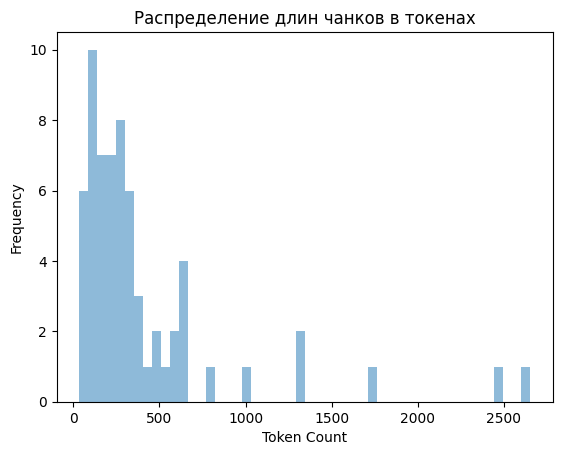

In [ ]:
def num_tokens_from_string(string: str, encoding_name: str) -> int:
      """Возвращает количество токенов в строке"""
      encoding = tiktoken.get_encoding(encoding_name)
      num_tokens = len(encoding.encode(string))
      return num_tokens

# Подсчет токенов для каждого фрагмента и построение графика
fragment_token_counts = [num_tokens_from_string(fragment.page_content, "cl100k_base") for fragment in documents]
plt.hist(fragment_token_counts, bins=50, alpha=0.5, label='Fragments')
plt.title('Распределение длин чанков в токенах')
plt.xlabel('Token Count')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Создаем пустой список для хранения фрагментов
docs_final = []

# Пороговое значение для количества токенов
threshold = 2000

# Перебираем каждый фрагмент
for fragment in documents:
    num_tokens = num_tokens_from_string(fragment.page_content, "cl100k_base")

    # Сохраняем название статьи из метаданных
    article_title = fragment.metadata['article_title']

    # Если фрагмент превышает пороговое значение, разбиваем его
    if num_tokens > threshold:
        text_splitter = RecursiveCharacterTextSplitter(chunk_size=2000)
        text_parts = text_splitter.split_text(fragment.page_content)

        for i, text_part in enumerate(text_parts):
            # Добавляем название статьи только ко второй и последующим частям, так как в первой он уже содержится
            if i == 0:
                docs_final.append(Document(
                    page_content=text_part,
                    metadata={'article_title': article_title}
                ))
            else:
                docs_final.append(Document(
                    page_content=article_title + '\n' + text_part,
                    metadata={'article_title': article_title}
                ))
    else:
        # Если фрагмент не превышает порог, добавляем его как есть
        docs_final.append(fragment)

In [ ]:
# всего получилось чанков:
len(docs_final)

78

In [ ]:
docs_final[:2]

[Document(page_content='PostgreSQL driver for Python — Psycopg\nPsycopg is the most popular PostgreSQL adapter for the Python programming language. Its core is a complete implementation of the Python DB API 2.0 specifications. Several extensions allow access to many of the features offered by PostgreSQL. Psycopg is released under the terms of the GNU Lesser General Public License, allowing use from both free and proprietary software.', metadata={'article_title': 'PostgreSQL driver for Python — Psycopg'}),
 Document(page_content='Latest articles — Psycopg\nPsycopg 3.1 released\n\nPosted by Daniele Varrazzo on 2022-08-30\n\n\nTagged as\nnews,\nrelease\n\nHello,\nAfter several months of development, we are proud to release Psycopg 3.1!\nPsycopg 3.1 is a gradual improvement on Psycopg 3.0, introducing new exciting\nfeatures, redefining what can be done on the boundary between Python and\nPostgreSQL.\nRead more...\n\n\nPsycopg 3.0 released\n\nPosted by Daniele Varrazzo on 2021-10-13\n\n\nTa

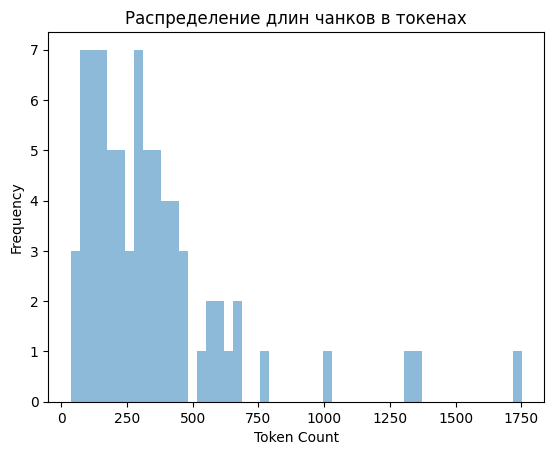

In [ ]:
# Проверяем, что больше нет чанков, превышающих 2000 токенов
def num_tokens_from_string_2(string: str, encoding_name: str) -> int:
      """Возвращает количество токенов в строке"""
      encoding = tiktoken.get_encoding(encoding_name)
      num_tokens = len(encoding.encode(string))
      return num_tokens

# Подсчет токенов для каждого фрагмента и построение графика
fragment_token_counts = [num_tokens_from_string_2(fragment.page_content, "cl100k_base") for fragment in docs_final]
plt.hist(fragment_token_counts, bins=50, alpha=0.5, label='Fragments')
plt.title('Распределение длин чанков в токенах')
plt.xlabel('Token Count')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Инициализирум модель эмбеддингов
embeddings = OpenAIEmbeddings()

# Создадим индексную базу из разделенных фрагментов текста
db = FAISS.from_documents(docs_final, embeddings)

In [ ]:
# Функция для загрузки документа по ссылке из Google Drive
def load_document_text(url: str) -> str:
    # Извлекаем идентификатор документа из URL
    match_ = re.search('/document/d/([a-zA-Z0-9-_]+)', url)
    if match_ is None:
        raise ValueError('Invalid Google Docs URL')
    doc_id = match_.group(1)

    # Загружаем документ в виде обычного текста
    response = requests.get(f'https://docs.google.com/document/d/{doc_id}/export?format=txt')
    response.raise_for_status()
    text = response.text

    return text

In [ ]:
system=load_document_text("https://docs.google.com/document/d/1PPVzFV4qu_-CouF0gLr4H73_A0-WPylRIskrfdUDm_E/edit?usp=sharing")

In [ ]:
def answer_index(system, topic, search_index, temp=0, verbose=0) -> str:
    """Функция возвращает ответ модели на основе заданной темы."""
    # находим наиболее релевантные вопросу пользователя чанки:
    docs = search_index.similarity_search(topic, k=3)
    message_content = re.sub(r'\n{2}', ' ', '\n '.join([f'\nОтрывок документа №{i+1}\n=====================' + doc.page_content + '\n' for i, doc in enumerate(docs)]))

    # если параметр verbose=1, то выводим релевантные чанки
    if verbose:
        print('message_content :\n', message_content)

    messages = [
        {"role": "system", "content": system},
        # в user промпт тоже пишем на английском - для экономии токенов
        {"role": "user", "content": f"Answer the user's question. Document with information for the user's answer: {message_content}\n\n User's question: \n{topic}"}
    ]

    completion = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=messages,
        temperature=temp
    )

    return completion.choices[0].message.content

In [ ]:
topic="Что такое psycopg?"                                                                          # укажите необходимое значение
ans=answer_index(system, topic, db, temp=0, verbose=0)
ans

'Psycopg - это самый популярный адаптер PostgreSQL для языка программирования Python. Он представляет собой обертку над библиотекой libpq, официальной клиентской библиотекой PostgreSQL. Psycopg полностью соответствует спецификациям Python DB API 2.0 и предоставляет доступ к многим возможностям, предлагаемым PostgreSQL. Psycopg выпущен под лицензией GNU Lesser General Public License, что позволяет использовать его как в свободном, так и в проприетарном программном обеспечении.'